In [58]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc
from sklearn.model_selection import KFold
import numpy as np
import itertools

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedShuffleSplit, train_test_split
from sklearn.utils import compute_sample_weight
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load data
india = pd.read_csv('india_clean.csv')
jordan = pd.read_csv('jordan_clean.csv')
florida = pd.read_csv('florida_clean.csv')
california = pd.read_csv('california_clean.csv')

# Ensure LOS >= 1
for df in [india, jordan, florida, california]:
    if "los" in df.columns:
        df["los"] = df["los"].clip(lower=1)

# Registry
dataset_registry = {
    "India": india,
    "Jordan": jordan,
    "Florida": florida,
    "California": california
}


# Prepare dataset combinations
dataset_names = list(dataset_registry.keys())
dataset_combos = []
for r in range(1, len(dataset_names)+1):
    dataset_combos.extend(itertools.combinations(dataset_names, r))

# Models to evaluate
model_defs = {
    "GBSA": GradientBoostingSurvivalAnalysis(n_estimators=150, random_state=0)
}

results = []

for combo in dataset_combos:
    # Concatenate datasets
    dfs = [dataset_registry[name] for name in combo]
    df_all = pd.concat(dfs, ignore_index=True)
    X = df_all[['age', 'sex', 'gcs']].values
    y = np.array([(bool(e), t) for e, t in zip(df_all['event'], df_all['los'])],
                 dtype=[('event', bool), ('time', float)])

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for model_name, model_proto in model_defs.items():
        cidxs = []
        aucs = []
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            model = model_proto.__class__(**model_proto.get_params())
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            cidx = concordance_index_censored(y_test["event"], y_test["time"], pred)[0]
            cidxs.append(cidx)
            # Time-dependent AUC at median time
            eval_times = np.quantile(y_test["time"], [0.25, 0.5, 0.75])
            auc_curve = []
            for t in eval_times:
                _, auc = cumulative_dynamic_auc(y_train, y_test, model.predict(X_test), times=t)
                auc_curve.append(auc)
            aucs.append(np.mean(auc_curve))
        results.append({
            "combo": combo,
            "model": model_name,
            "cindex_mean": np.mean(cidxs),
            "cindex_std": np.std(cidxs),
            "auc_mean": np.mean(aucs),
            "auc_std": np.std(aucs)
        })

# Sort and display top models
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["cindex_mean", "auc_mean"], ascending=False)
print(results_df.head())

# Example: Unit test for best model
best = results_df.iloc[0]
combo = best['combo']
model_name = best['model']
dfs = [dataset_registry[name] for name in combo]
df_all = pd.concat(dfs, ignore_index=True)
X = df_all[['age', 'sex', 'gcs']].values
y = np.array([(bool(e), t) for e, t in zip(df_all['event'], df_all['los'])],
             dtype=[('event', bool), ('time', float)])
model_proto = model_defs[model_name]
model = model_proto.__class__(**model_proto.get_params())
model.fit(X, y)

# Unit test: predict survival curve for a sample patient
sample = X[0].reshape(1, -1)
surv_fn = model.predict_survival_function(sample)
assert surv_fn is not None and hasattr(surv_fn[0], '__call__'), "Model did not return a survival function"
print("Unit test passed: Model returns a survival probability curve.")

ValueError: censoring survival function is zero at one or more time points

C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\2557104500.py:90: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


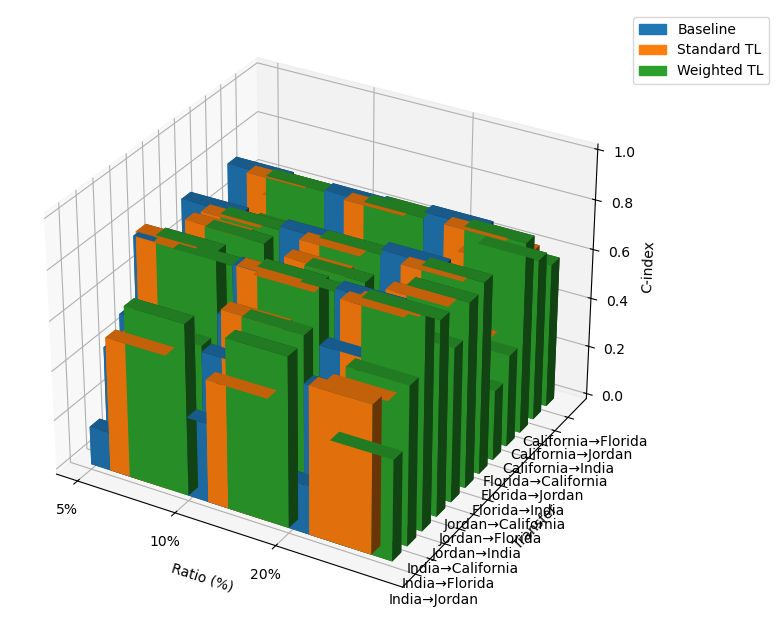

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import matplotlib.pyplot as plt

# Prepare data
ratios = [5, 10, 20]
transfers = [
    "India→Jordan", "India→Florida", "India→California",
    "Jordan→India", "Jordan→Florida", "Jordan→California",
    "Florida→India", "Florida→Jordan", "Florida→California",
    "California→India", "California→Jordan", "California→Florida"
]
model_types = ["Baseline", "Standard TL", "Weighted TL"]

# C-index values for each (transfer, ratio, model_type)
# Fill in order: for each transfer, for each ratio, for each model_type
cindex_data = [
    # India→Jordan
    [0.155, 0.541, 0.689], [0.318, 0.493, 0.682], [0.196, 0.595, 0.405],
    # India→Florida
    [0.425, 0.510, 0.550], [0.526, 0.716, 0.710], [0.522, 0.552, 0.637],
    # India→California
    [0.506, 0.857, 0.864], [0.625, 0.836, 0.855], [0.618, 0.820, 0.850],
    # Jordan→India
    [0.768, 0.764, 0.762], [0.766, 0.749, 0.775], [0.786, 0.770, 0.781],
    # Jordan→Florida
    [0.425, 0.433, 0.421], [0.526, 0.619, 0.548], [0.522, 0.599, 0.619],
    # Jordan→California
    [0.506, 0.755, 0.748], [0.625, 0.718, 0.707], [0.618, 0.704, 0.744],
    # Florida→India
    [0.768, 0.739, 0.752], [0.766, 0.737, 0.767], [0.786, 0.751, 0.770],
    # Florida→Jordan
    [0.155, 0.196, 0.385], [0.318, 0.426, 0.426], [0.196, 0.324, 0.284],
    # Florida→California
    [0.506, 0.347, 0.628], [0.625, 0.443, 0.368], [0.618, 0.417, 0.373],
    # California→India
    [0.768, 0.753, 0.760], [0.766, 0.749, 0.762], [0.786, 0.760, 0.773],
    # California→Jordan
    [0.155, 0.615, 0.696], [0.318, 0.439, 0.709], [0.196, 0.601, 0.655],
    # California→Florida
    [0.425, 0.554, 0.494], [0.526, 0.593, 0.577], [0.522, 0.613, 0.585],
]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare bar positions
n_transfers = len(transfers)
n_ratios = len(ratios)
n_models = len(model_types)

x_pos = []
y_pos = []
z_pos = []
dx = 0.6
dy = 0.6
dz = []

for t_idx in range(n_transfers):
    for r_idx in range(n_ratios):
        for m_idx in range(n_models):
            x_pos.append(r_idx + m_idx * 0.2)  # ratio axis, offset by model
            y_pos.append(t_idx)
            z_pos.append(m_idx)
            dz.append(cindex_data[t_idx * n_ratios + r_idx][m_idx])

# Colors for models
colors = ['tab:blue', 'tab:orange', 'tab:green']
bar_colors = [colors[m_idx] for t_idx in range(n_transfers) for r_idx in range(n_ratios) for m_idx in range(n_models)]

ax.bar3d(x_pos, y_pos, [0]*len(z_pos), dx, dy, dz, color=bar_colors, shade=True)

# Set axes labels
ax.set_xlabel('Ratio (%)')
ax.set_ylabel('Transfer')
ax.set_zlabel('C-index')

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['5%', '10%', '20%'])
ax.set_yticks(range(n_transfers))
ax.set_yticklabels(transfers)
ax.set_zlim(0, 1)

# Legend
from matplotlib.patches import Patch
legend_patches = [Patch(color=colors[m_idx], label=model) for m_idx, model in enumerate(model_types)]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\3574786266.py:94: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.

C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\3574786266.py:94: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.

C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\3574786266.py:94: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.

C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\3574786266.py:94: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



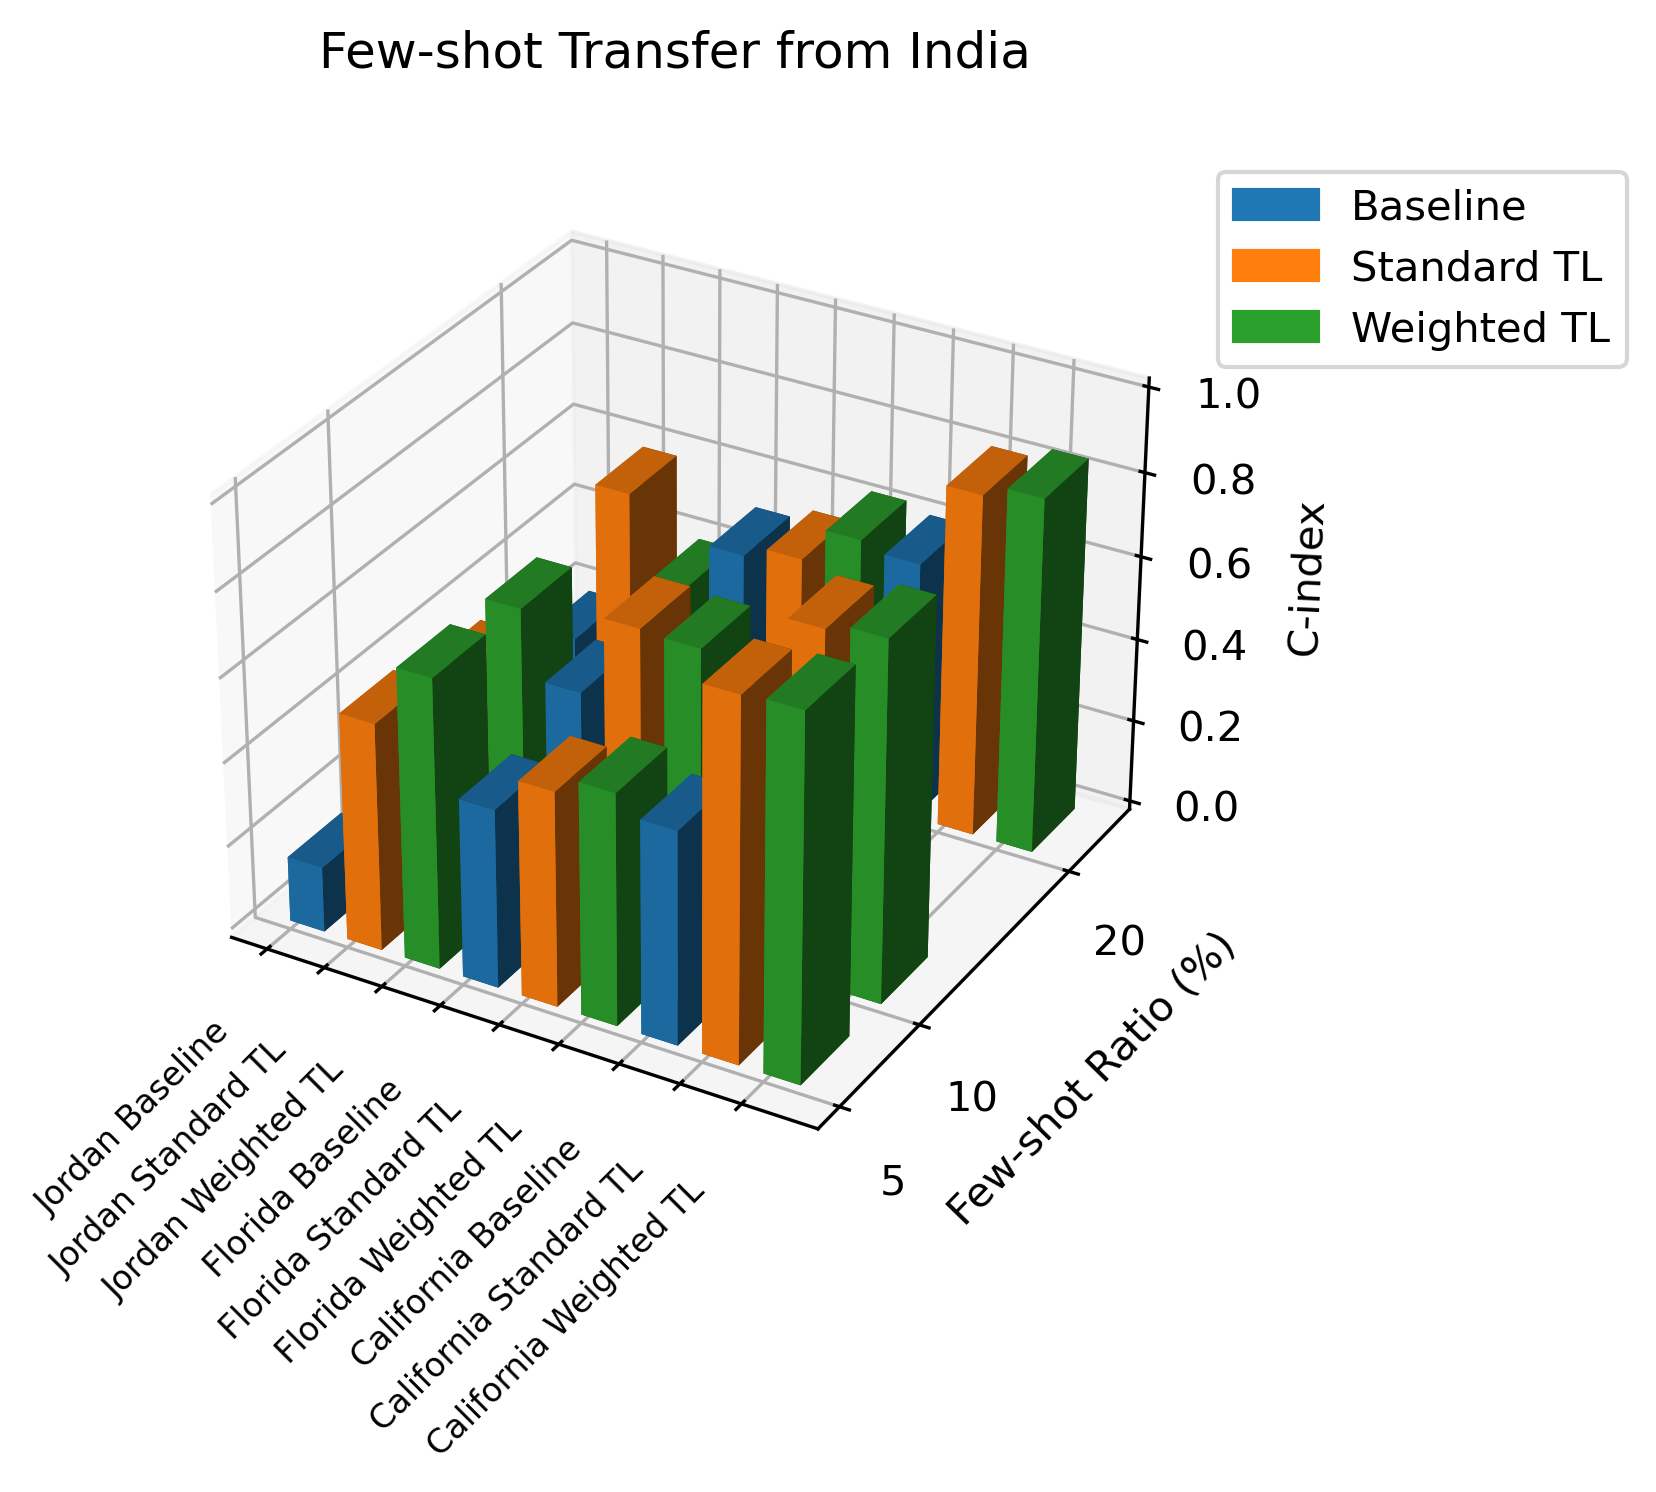

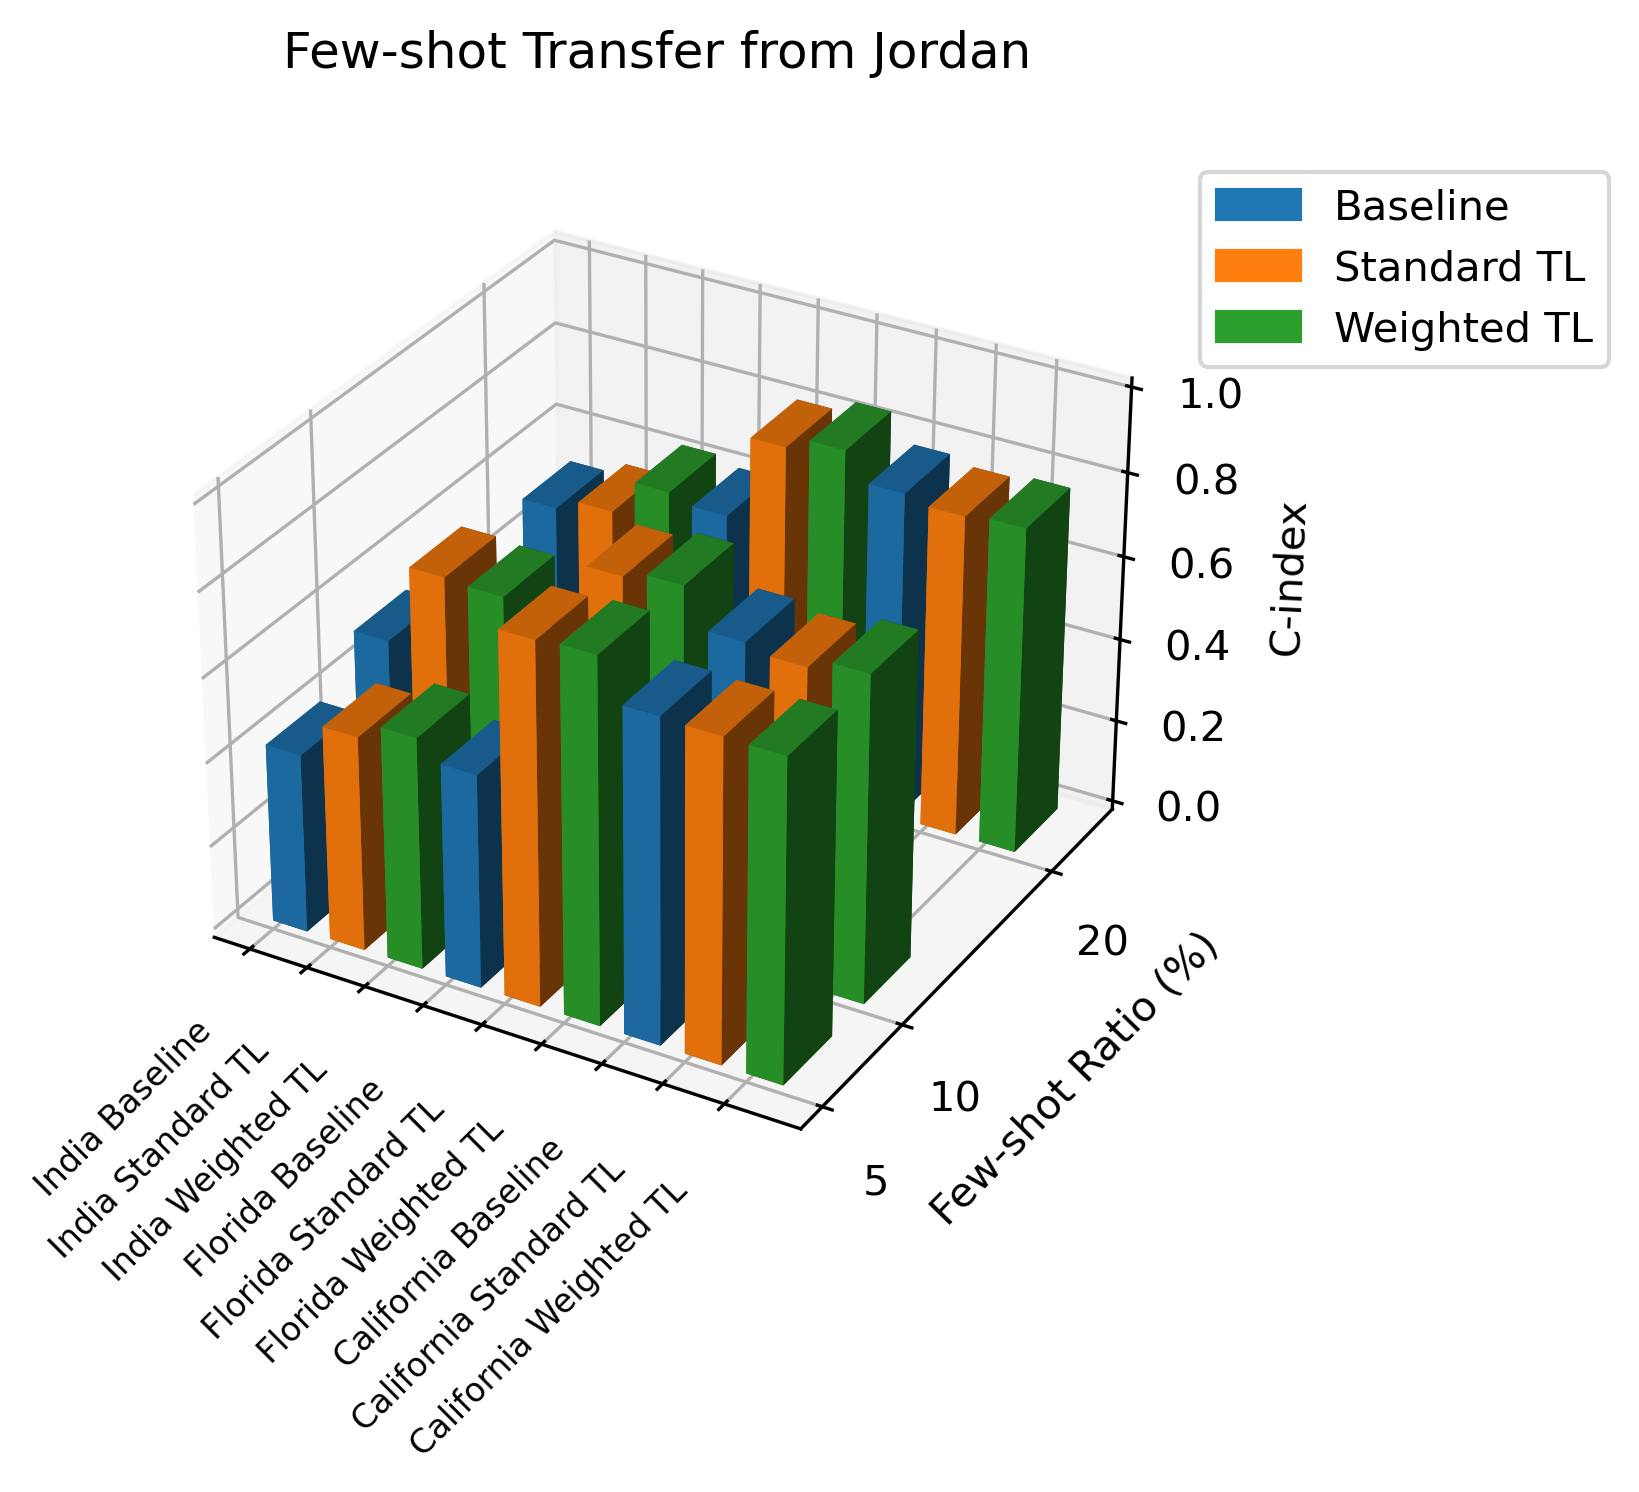

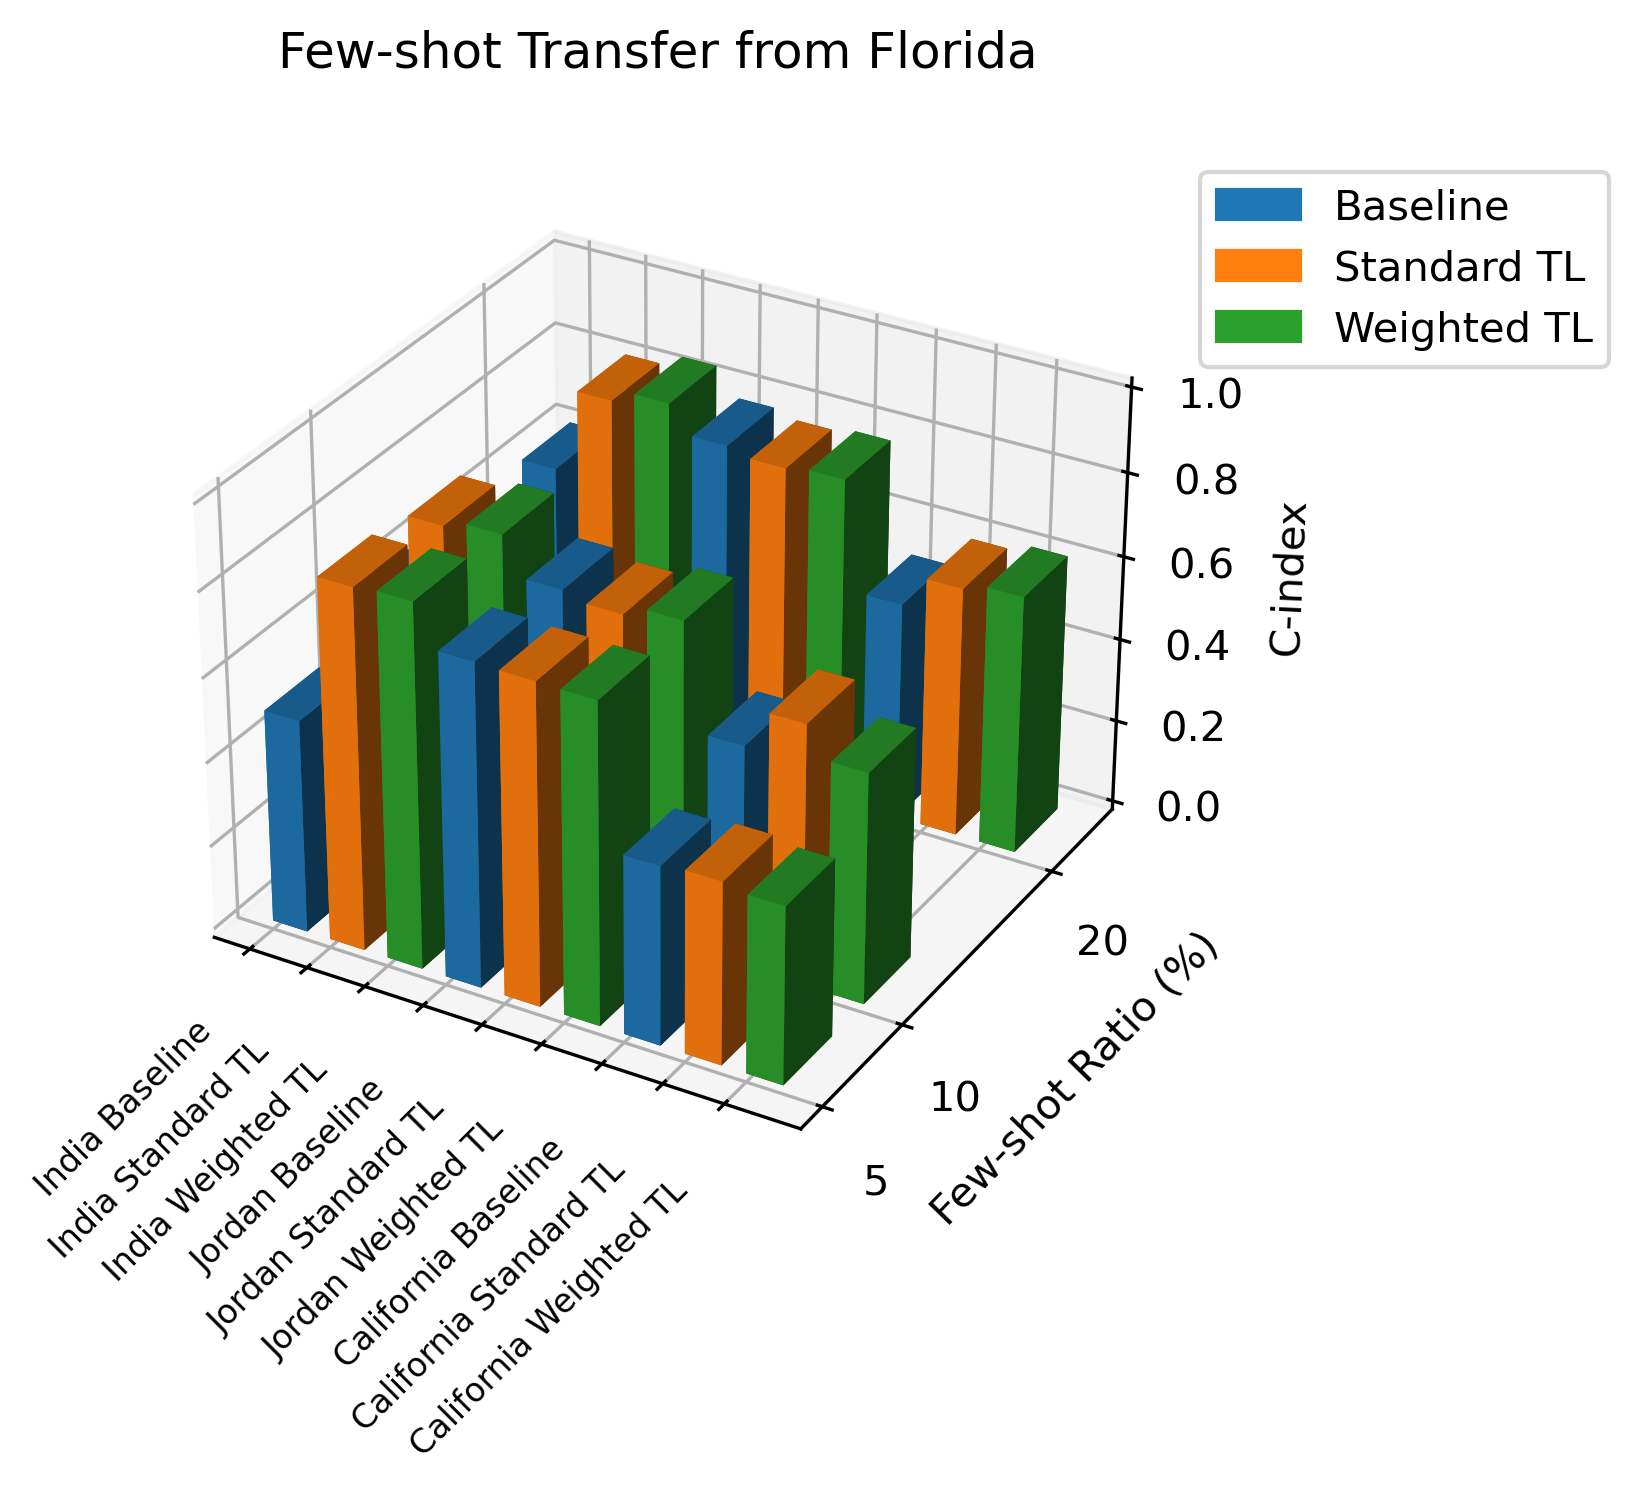

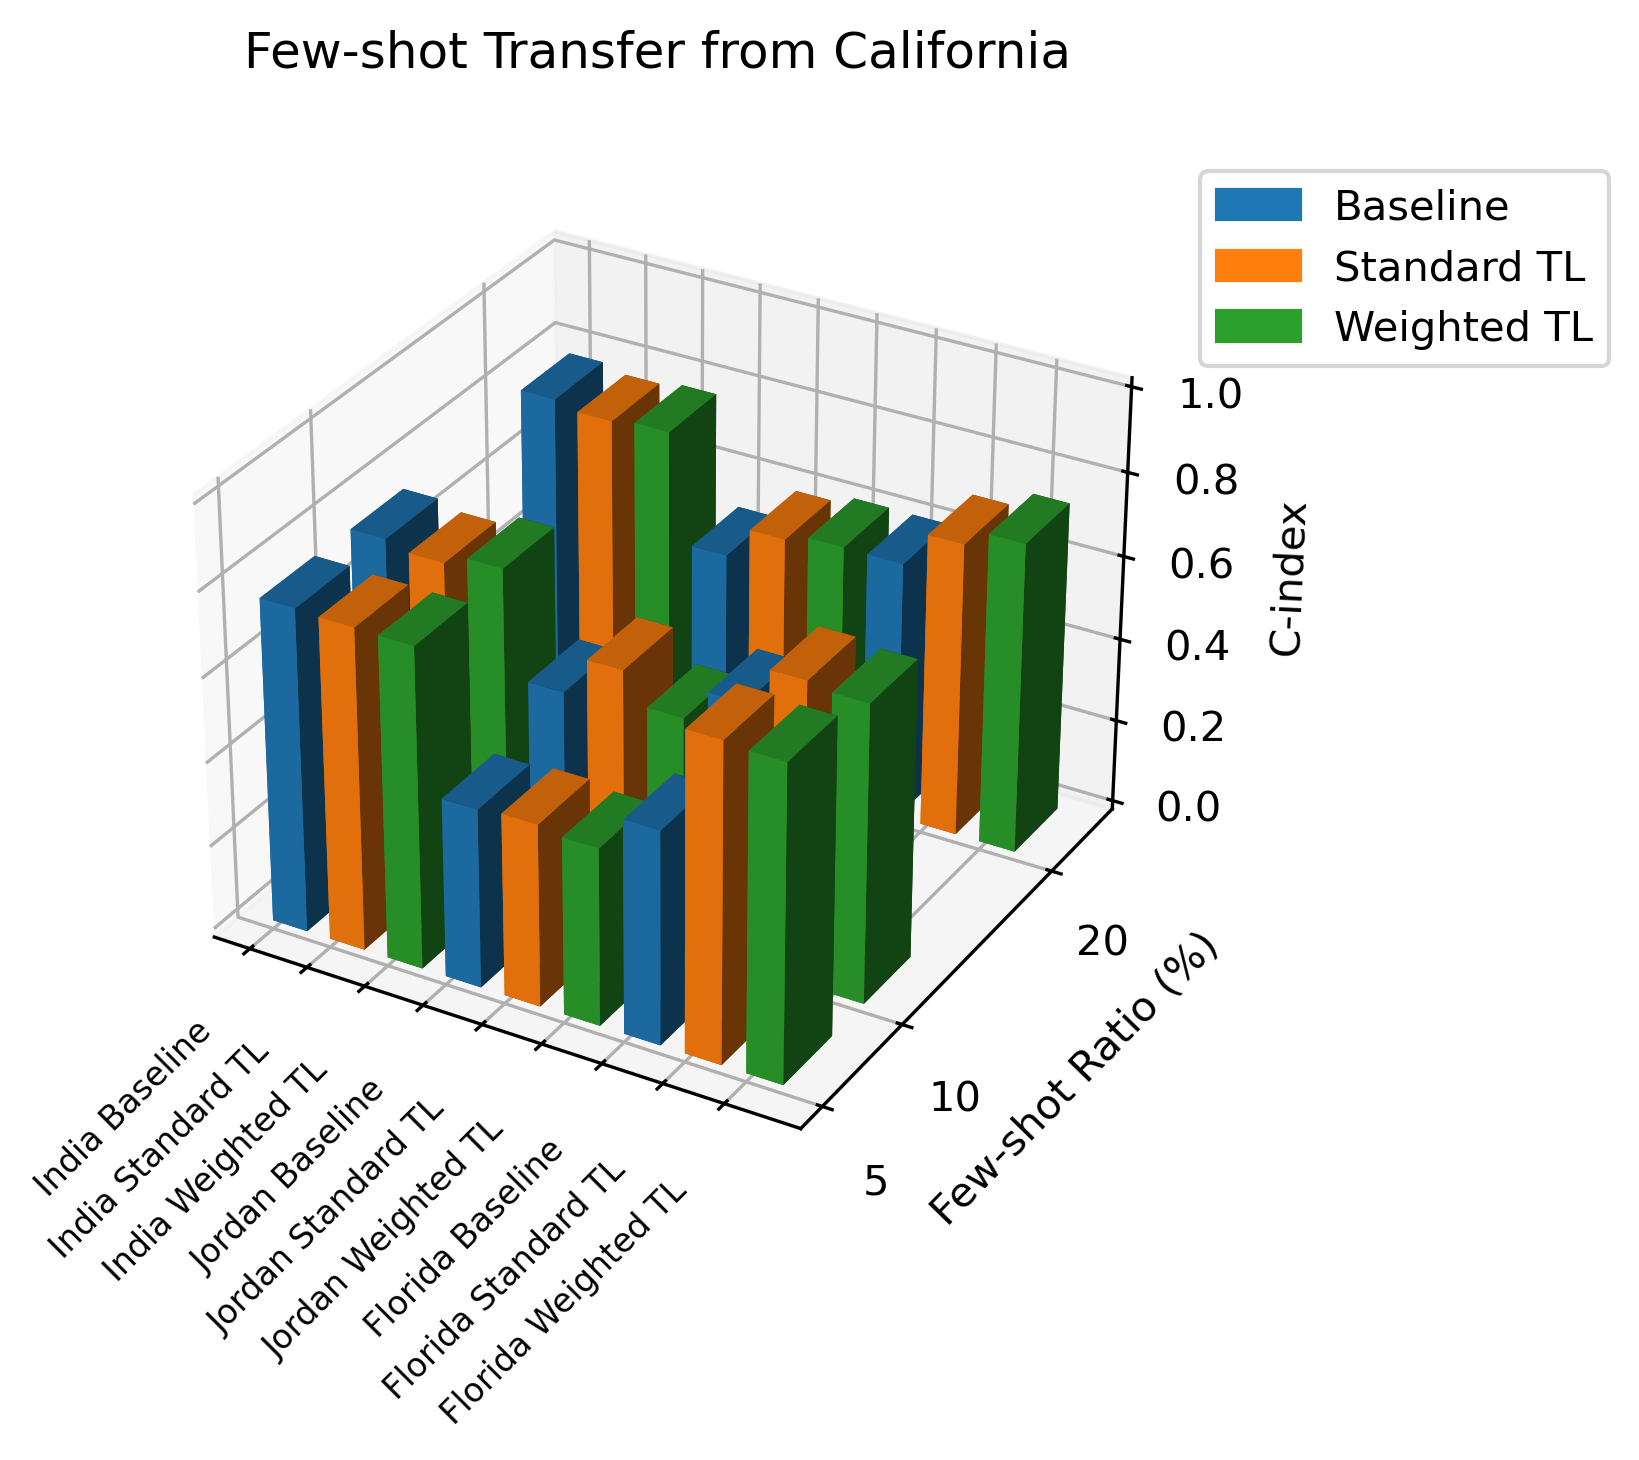

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Setup
sources = ["India", "Jordan", "Florida", "California"]
targets = ["Jordan", "Florida", "California", "India", "Jordan", "California", "India", "Jordan", "California"]
model_types = ["Baseline", "Standard TL", "Weighted TL"]
ratios = [5, 10, 20]

# Mapping (source, target) → rows in cindex_data
source_target_pairs = [
    ("India", "Jordan"), ("India", "Florida"), ("India", "California"),
    ("Jordan", "India"), ("Jordan", "Florida"), ("Jordan", "California"),
    ("Florida", "India"), ("Florida", "Jordan"), ("Florida", "California"),
    ("California", "India"), ("California", "Jordan"), ("California", "Florida")
]

# Provided C-index values
cindex_data = [
    # India→Jordan
    [0.155, 0.541, 0.689], [0.318, 0.493, 0.682], [0.196, 0.595, 0.405],
    # India→Florida
    [0.425, 0.510, 0.550], [0.526, 0.716, 0.710], [0.522, 0.552, 0.637],
    # India→California
    [0.506, 0.857, 0.864], [0.625, 0.836, 0.855], [0.618, 0.820, 0.850],
    # Jordan→India
    [0.768, 0.764, 0.762], [0.766, 0.749, 0.775], [0.786, 0.770, 0.781],
    # Jordan→Florida
    [0.425, 0.433, 0.421], [0.526, 0.619, 0.548], [0.522, 0.599, 0.619],
    # Jordan→California
    [0.506, 0.755, 0.748], [0.625, 0.718, 0.707], [0.618, 0.704, 0.744],
    # Florida→India
    [0.768, 0.739, 0.752], [0.766, 0.737, 0.767], [0.786, 0.751, 0.770],
    # Florida→Jordan
    [0.155, 0.196, 0.385], [0.318, 0.426, 0.426], [0.196, 0.324, 0.284],
    # Florida→California
    [0.506, 0.347, 0.628], [0.625, 0.443, 0.368], [0.618, 0.417, 0.373],
    # California→India
    [0.768, 0.753, 0.760], [0.766, 0.749, 0.762], [0.786, 0.760, 0.773],
    # California→Jordan
    [0.155, 0.615, 0.696], [0.318, 0.439, 0.709], [0.196, 0.601, 0.655],
    # California→Florida
    [0.425, 0.554, 0.494], [0.526, 0.593, 0.577], [0.522, 0.613, 0.585],
]

# Color mapping
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Create a 3D bar chart per source
figs = []
for source in sources:
    fig = plt.figure(figsize=(12, 6), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    x_pos, y_pos, z_pos, dx, dy, dz, bar_colors = [], [], [], [], [], [], []

    transfers_from_source = [t for s, t in source_target_pairs if s == source]
    index_offset = source_target_pairs.index((source, transfers_from_source[0]))

    for i, target in enumerate(transfers_from_source):
        for j, ratio in enumerate(ratios):
            row = index_offset + i * 3 + j
            for k, model in enumerate(model_types):
                x = i * len(model_types) + k  # Group by target and model
                y = ratio
                x_pos.append(x)
                y_pos.append(y)
                z_pos.append(0)
                dx.append(0.6)
                dy.append(3)
                dz.append(cindex_data[row][k])
                bar_colors.append(colors[k])

    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=bar_colors, shade=True)

    ax.set_ylabel('Few-shot Ratio (%)')
    ax.set_zlabel('C-index')

    ax.set_yticks(ratios)
    ax.set_zlim(0, 1)

    ax.set_title(f'Few-shot Transfer from {source}', pad=20)

    xtick_labels = [f"{t} {m}" for t in transfers_from_source for m in model_types]
    ax.set_xticks(range(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)

    from matplotlib.patches import Patch
    legend_patches = [Patch(color=colors[i], label=model_types[i]) for i in range(3)]
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

    plt.subplots_adjust(bottom=0.3)  # Increase bottom padding to avoid label overlap

    plt.tight_layout()
    figs.append(fig)

plt.show()



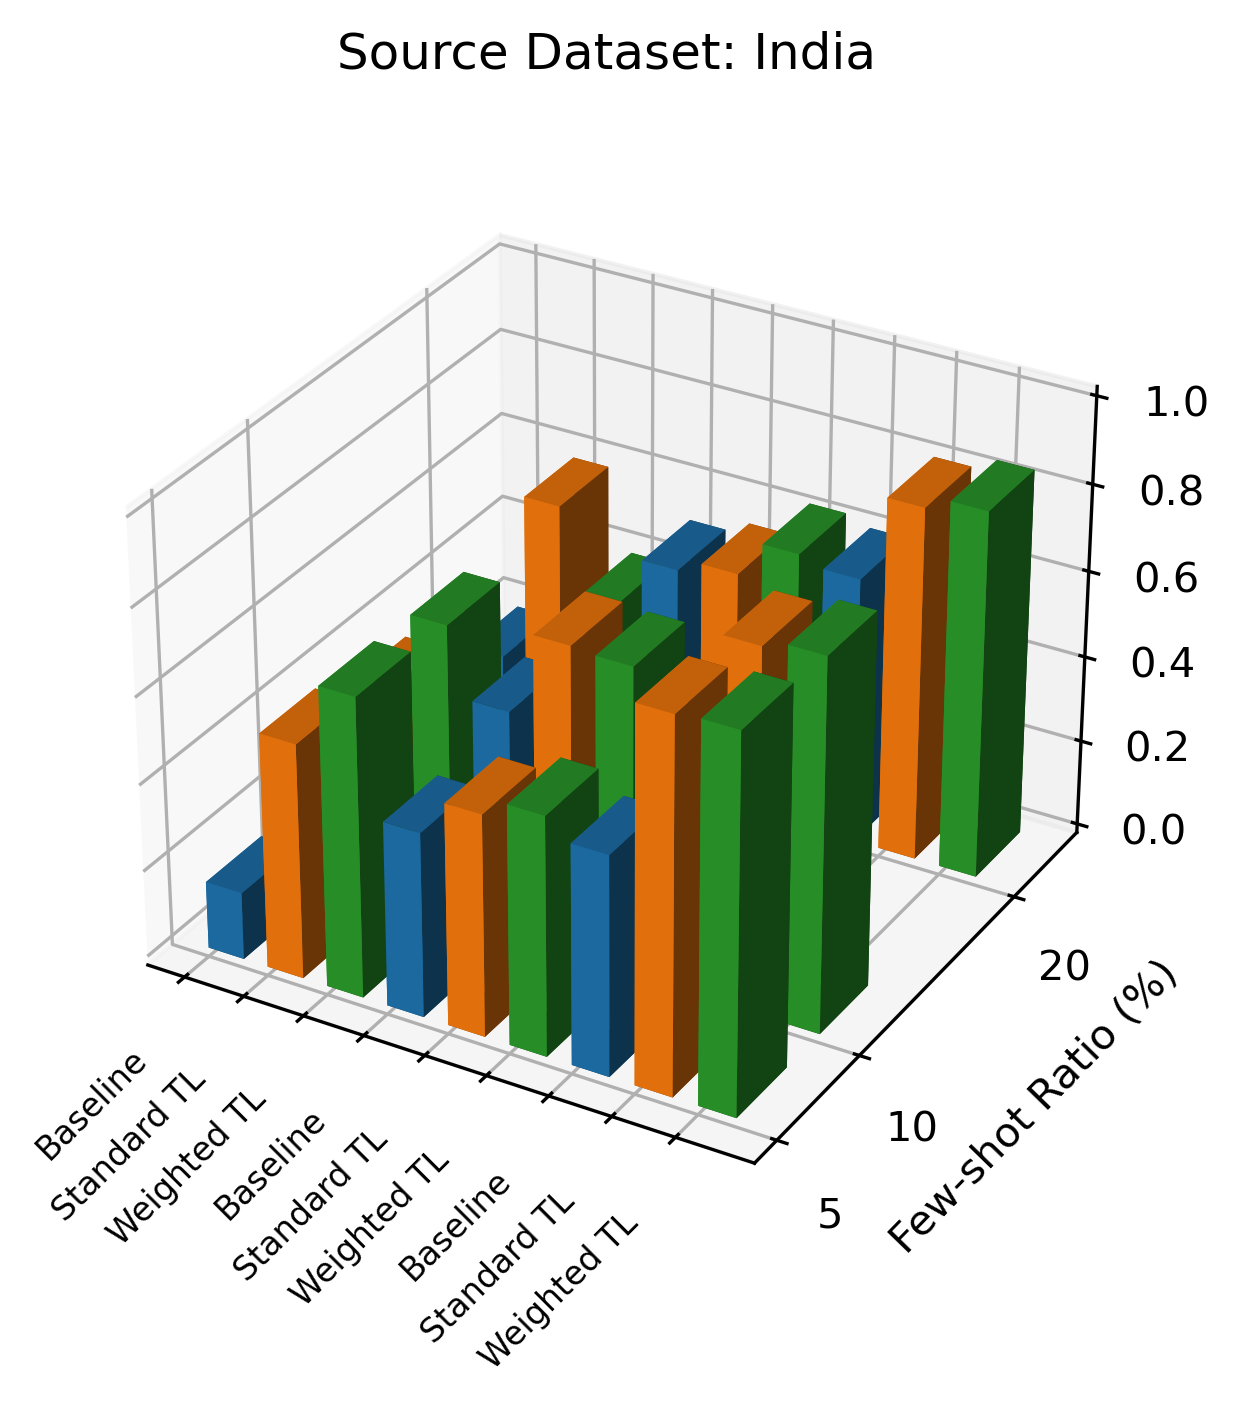

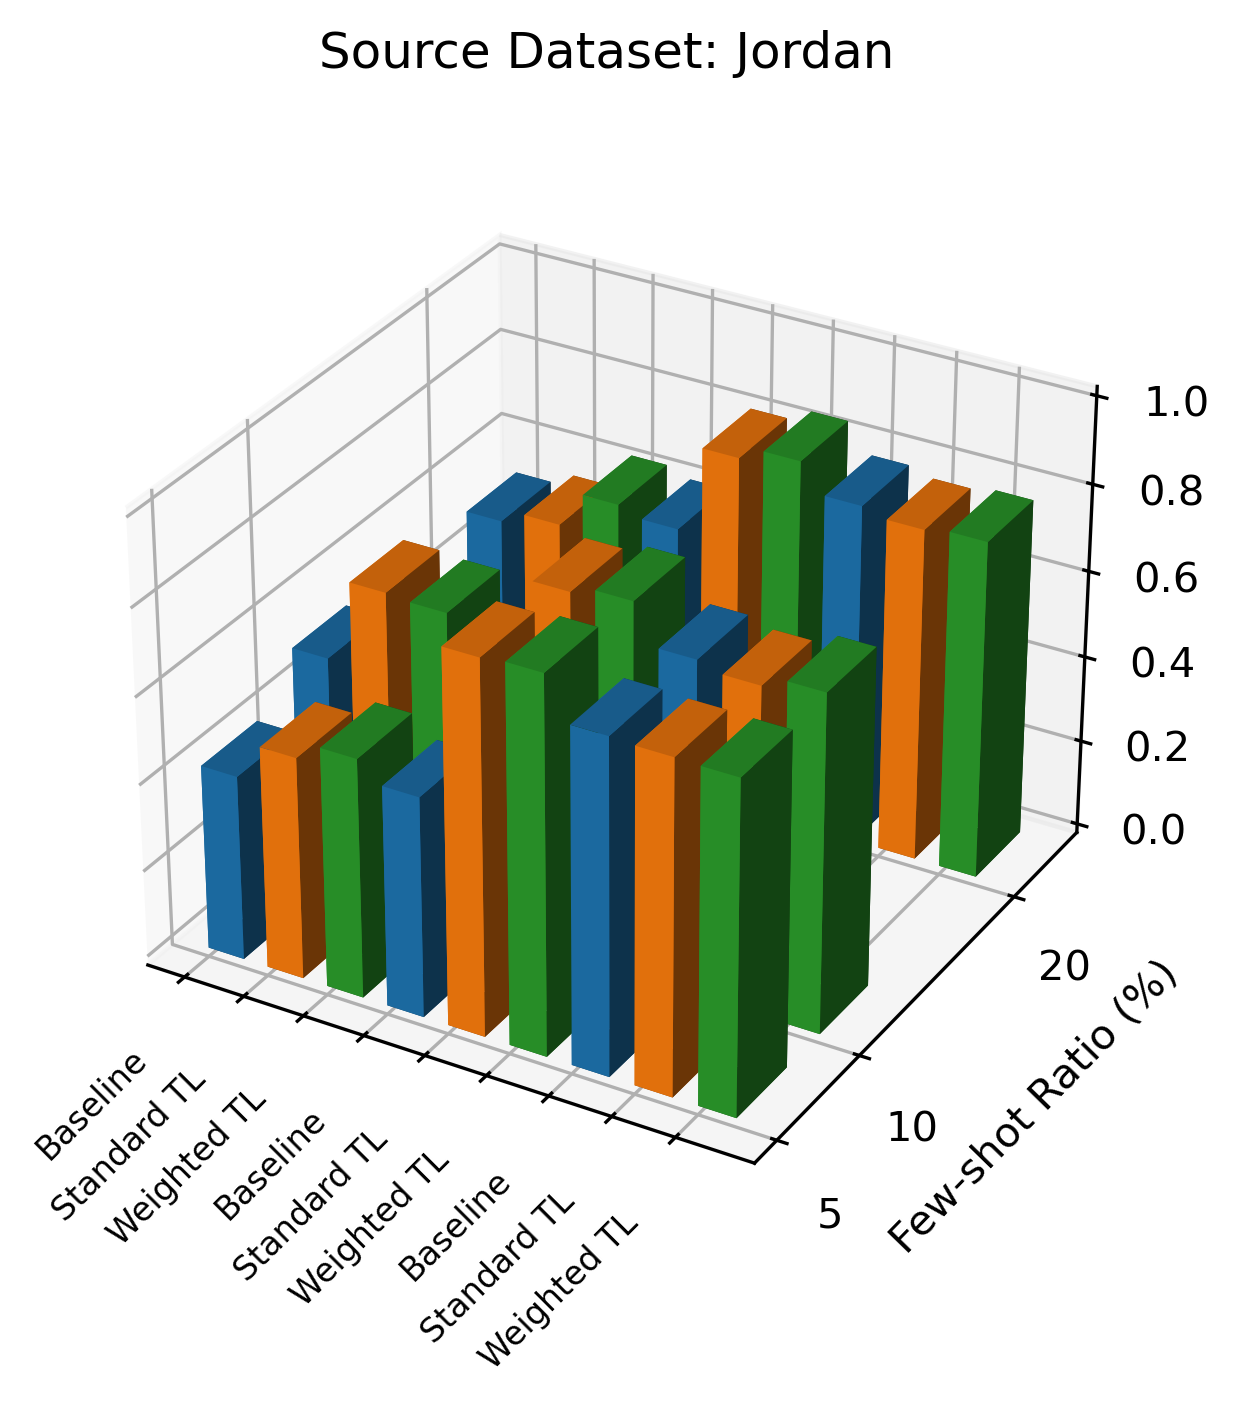

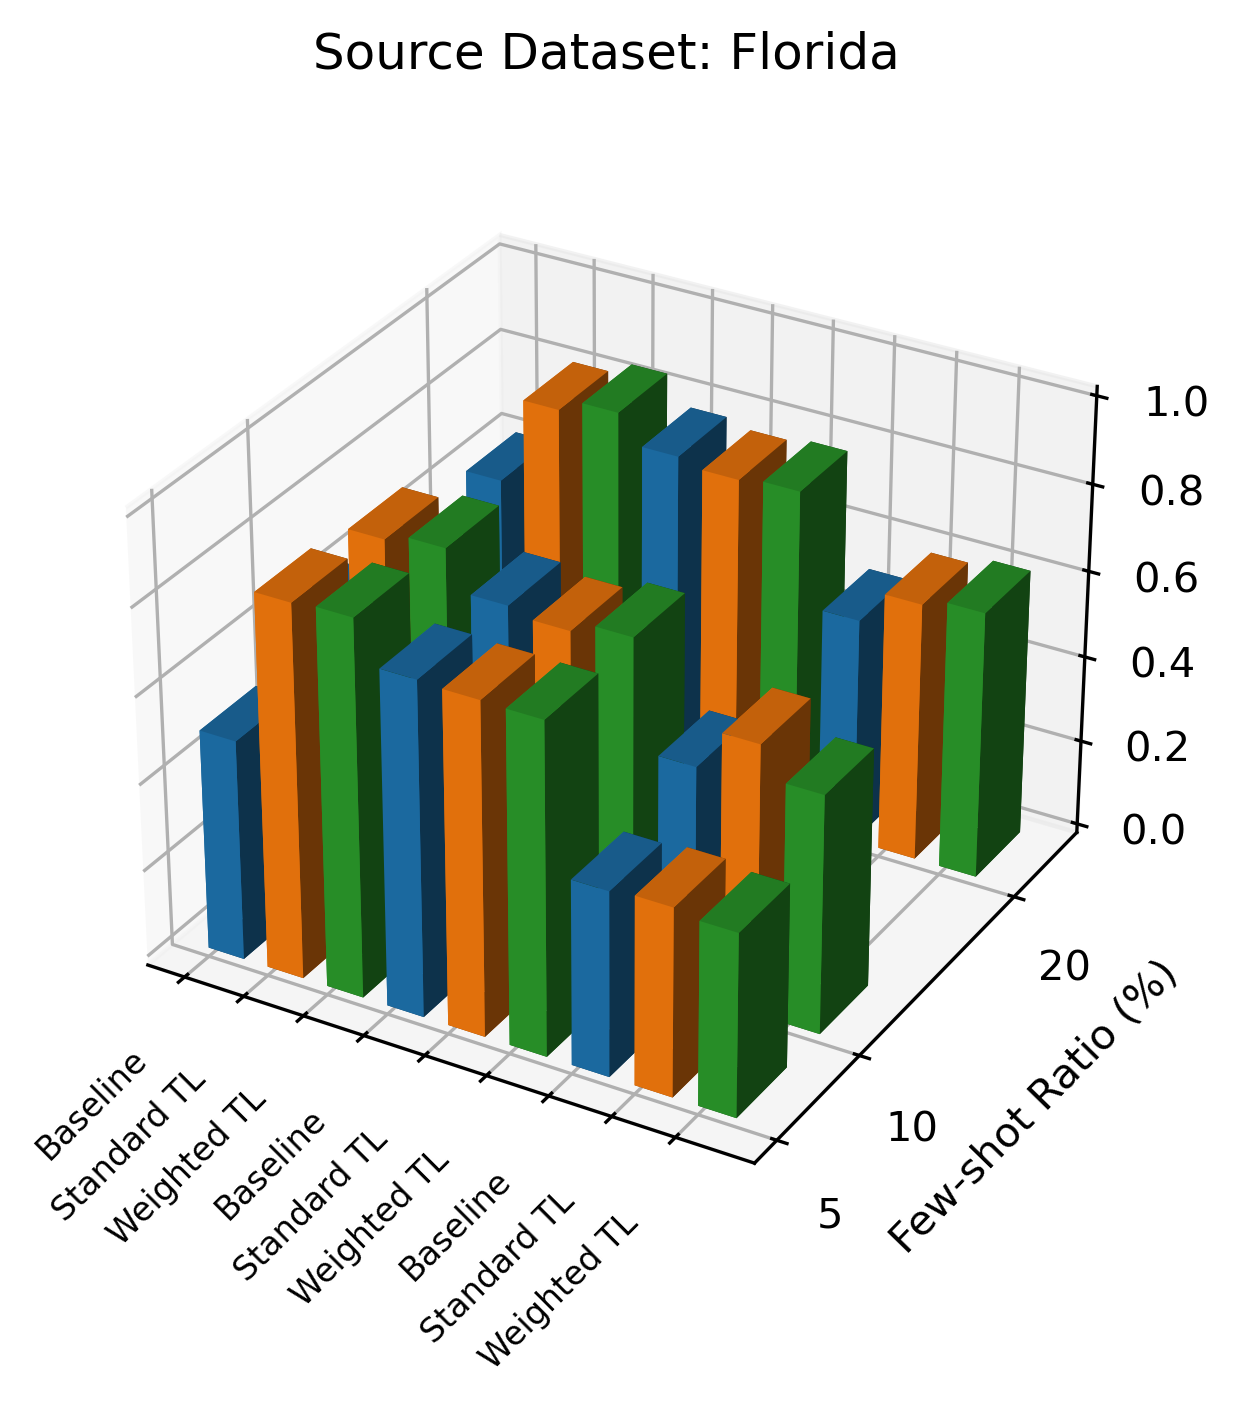

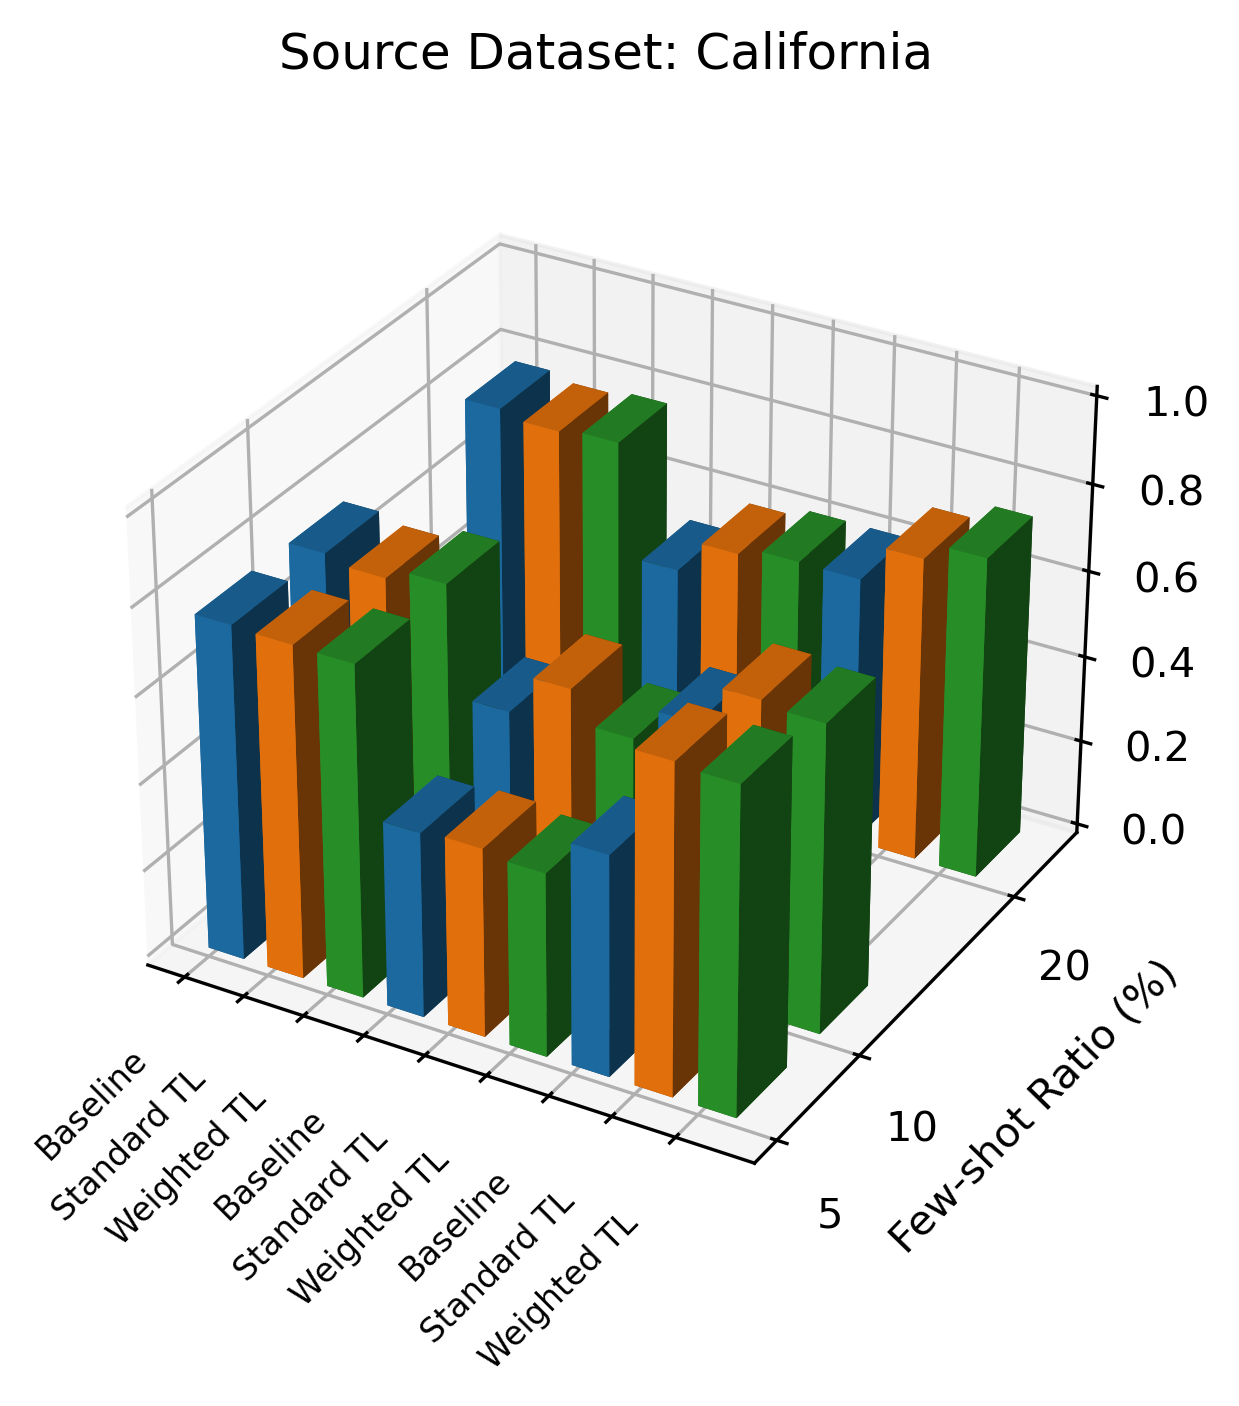

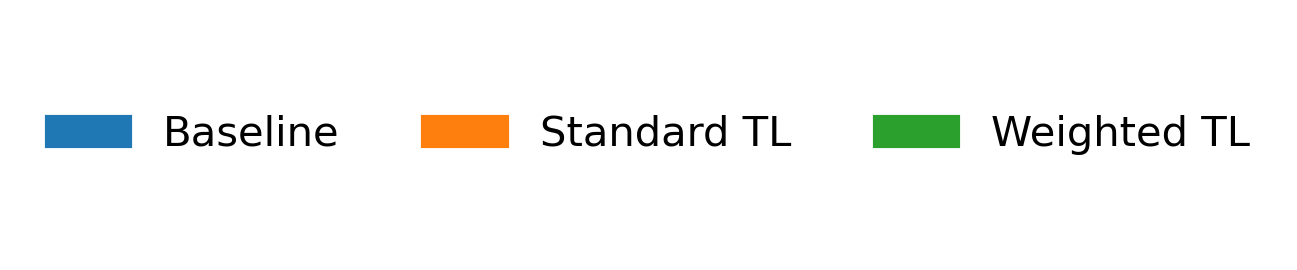

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Setup
sources = ["India", "Jordan", "Florida", "California"]
targets = ["Jordan", "Florida", "California", "India", "Jordan", "California", "India", "Jordan", "California"]
model_types = ["Baseline", "Standard TL", "Weighted TL"]
ratios = [5, 10, 20]

# Mapping (source, target) → rows in cindex_data
source_target_pairs = [
    ("India", "Jordan"), ("India", "Florida"), ("India", "California"),
    ("Jordan", "India"), ("Jordan", "Florida"), ("Jordan", "California"),
    ("Florida", "India"), ("Florida", "Jordan"), ("Florida", "California"),
    ("California", "India"), ("California", "Jordan"), ("California", "Florida")
]

# Provided C-index values
cindex_data = [
    # India→Jordan
    [0.155, 0.541, 0.689], [0.318, 0.493, 0.682], [0.196, 0.595, 0.405],
    # India→Florida
    [0.425, 0.510, 0.550], [0.526, 0.716, 0.710], [0.522, 0.552, 0.637],
    # India→California
    [0.506, 0.857, 0.864], [0.625, 0.836, 0.855], [0.618, 0.820, 0.850],
    # Jordan→India
    [0.768, 0.764, 0.762], [0.766, 0.749, 0.775], [0.786, 0.770, 0.781],
    # Jordan→Florida
    [0.425, 0.433, 0.421], [0.526, 0.619, 0.548], [0.522, 0.599, 0.619],
    # Jordan→California
    [0.506, 0.755, 0.748], [0.625, 0.718, 0.707], [0.618, 0.704, 0.744],
    # Florida→India
    [0.768, 0.739, 0.752], [0.766, 0.737, 0.767], [0.786, 0.751, 0.770],
    # Florida→Jordan
    [0.155, 0.196, 0.385], [0.318, 0.426, 0.426], [0.196, 0.324, 0.284],
    # Florida→California
    [0.506, 0.347, 0.628], [0.625, 0.443, 0.368], [0.618, 0.417, 0.373],
    # California→India
    [0.768, 0.753, 0.760], [0.766, 0.749, 0.762], [0.786, 0.760, 0.773],
    # California→Jordan
    [0.155, 0.615, 0.696], [0.318, 0.439, 0.709], [0.196, 0.601, 0.655],
    # California→Florida
    [0.425, 0.554, 0.494], [0.526, 0.593, 0.577], [0.522, 0.613, 0.585],
]

# Color mapping
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Create a 3D bar chart per source
figs = []
for source in sources:
    fig = plt.figure(figsize=(10, 6), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    x_pos, y_pos, z_pos, dx, dy, dz, bar_colors = [], [], [], [], [], [], []

    transfers_from_source = [t for s, t in source_target_pairs if s == source]
    index_offset = source_target_pairs.index((source, transfers_from_source[0]))

    for i, target in enumerate(transfers_from_source):
        for j, ratio in enumerate(ratios):
            row = index_offset + i * 3 + j
            for k, model in enumerate(model_types):
                x = i * len(model_types) + k  # Group by target and model
                y = ratio
                x_pos.append(x)
                y_pos.append(y)
                z_pos.append(0)
                dx.append(0.6)
                dy.append(3)
                dz.append(cindex_data[row][k])
                bar_colors.append(colors[k])

    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=bar_colors, shade=True)

    ax.set_ylabel('Few-shot Ratio (%)')
    ax.set_zlabel('C-index', labelpad=25)

    ax.set_yticks(ratios)
    ax.set_zlim(0, 1)

    ax.set_title(f'Source Dataset: {source}', pad=20)

    xtick_labels = model_types * len(transfers_from_source)
    ax.set_xticks(range(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)

    from matplotlib.patches import Patch
    

    plt.subplots_adjust(left=0.15, bottom=0.3, top=0.9, right=0.95)

    figs.append(fig)

plt.show()

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define model types and corresponding colors
model_types = ["Baseline", "Standard TL", "Weighted TL"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Create legend-only figure
fig, ax = plt.subplots(figsize=(4, 1), dpi=300)
legend_patches = [Patch(color=colors[i], label=model_types[i]) for i in range(3)]
legend = ax.legend(handles=legend_patches, loc='center', ncol=3, frameon=False)
ax.axis('off')

plt.tight_layout()
plt.show()



C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\712083450.py:91: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



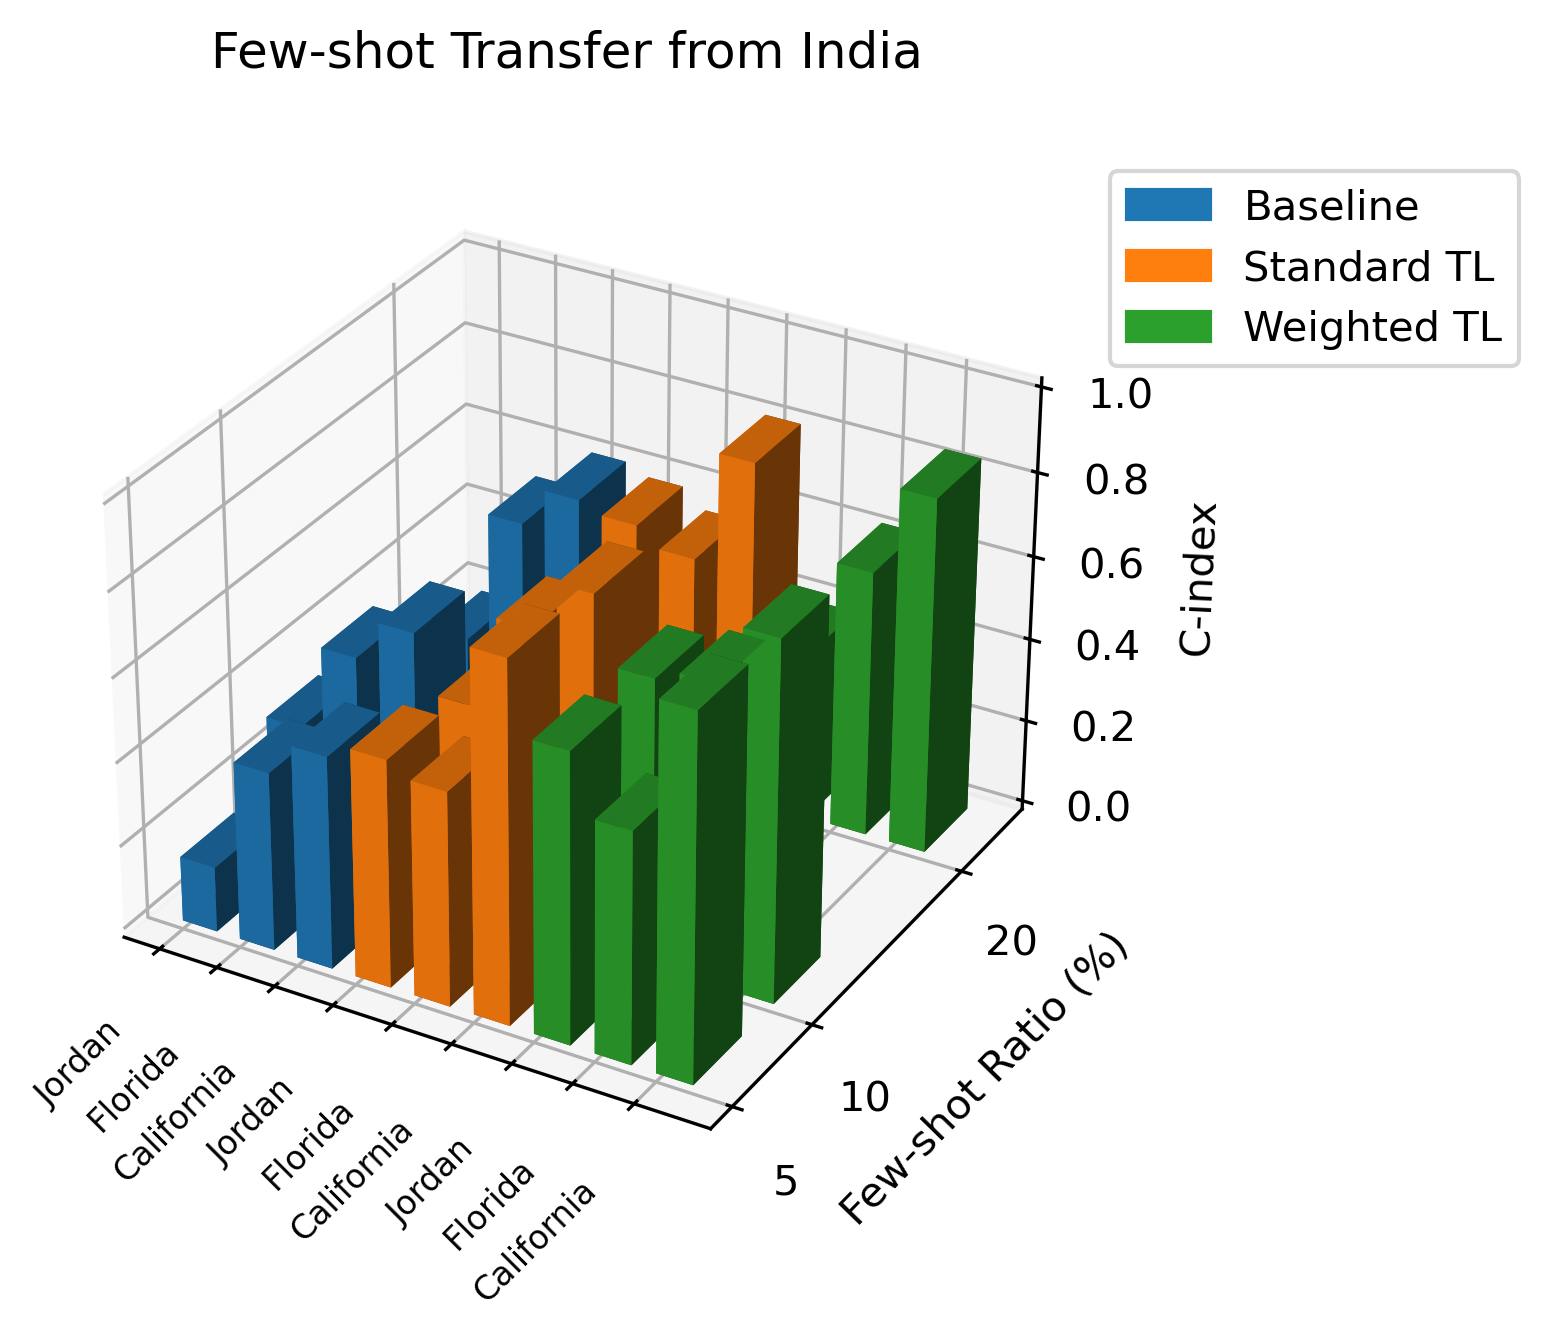

C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\712083450.py:91: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



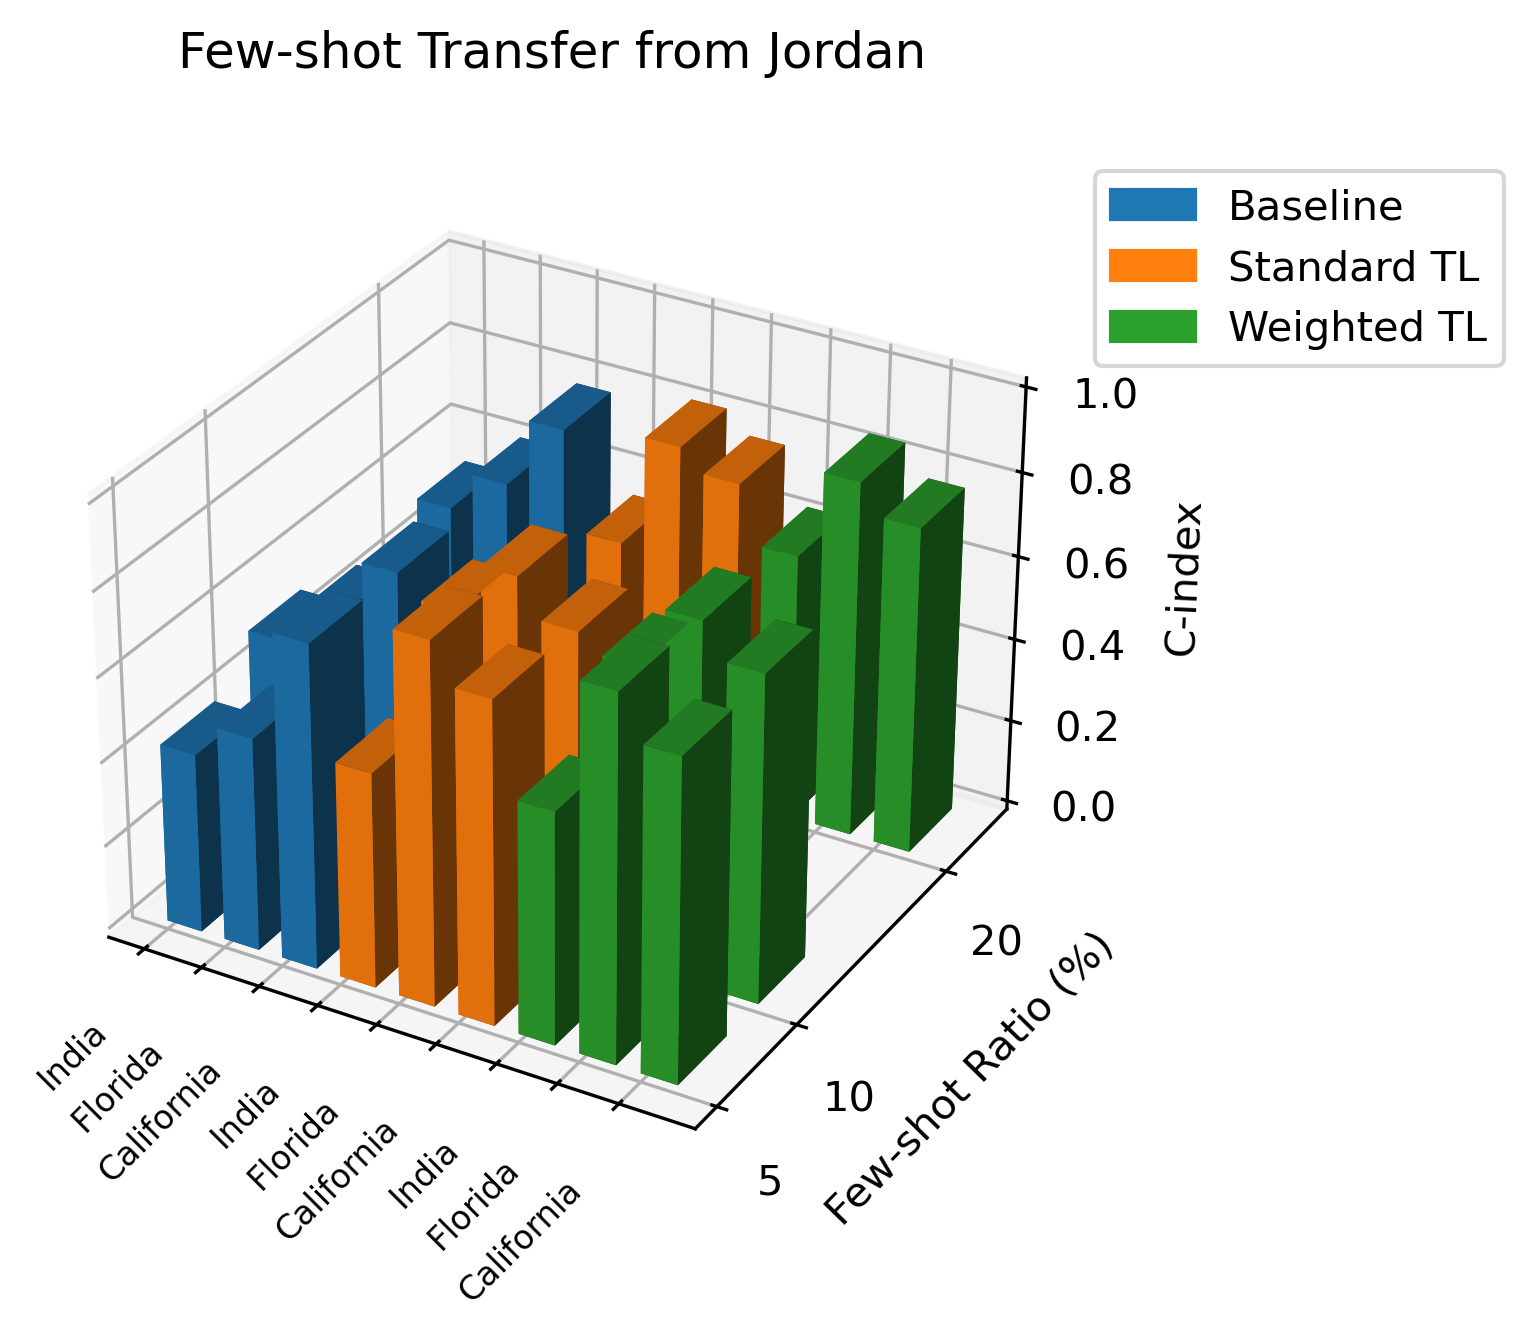

C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\712083450.py:91: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



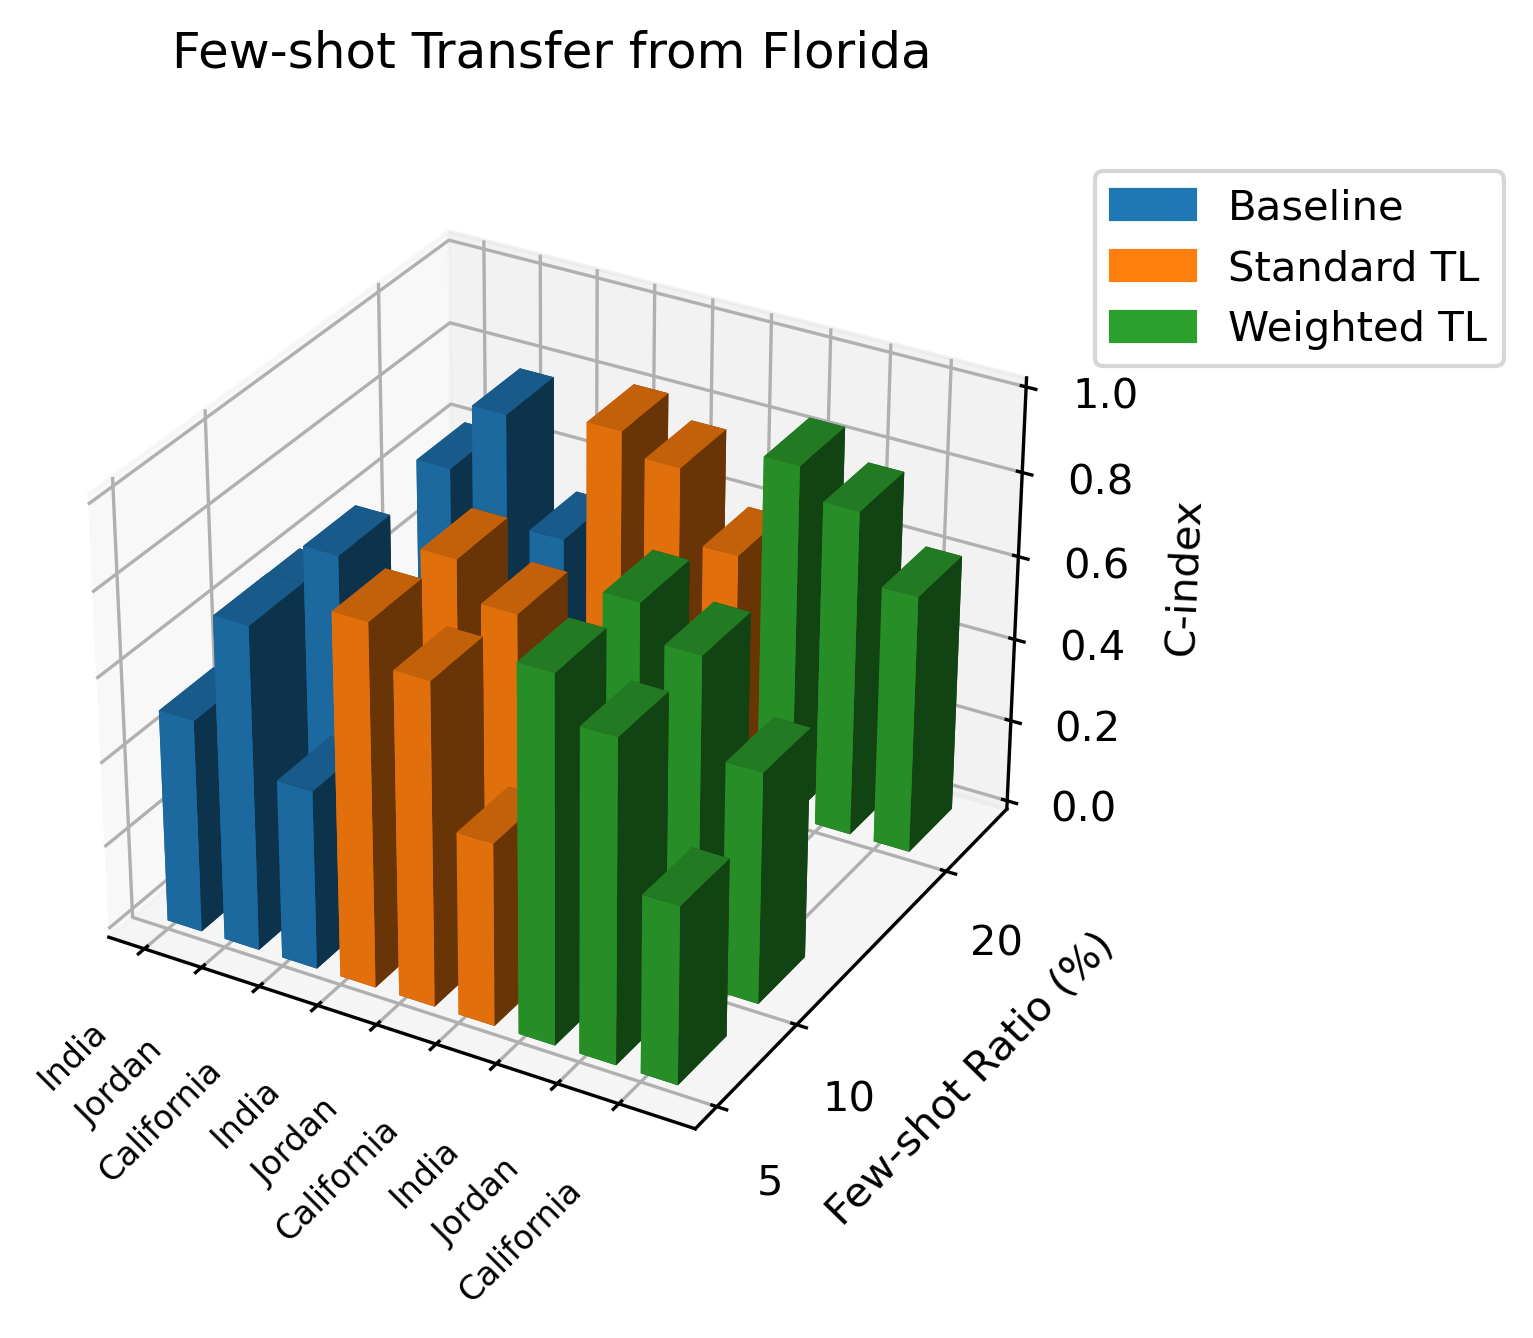

C:\Users\shrin\AppData\Local\Temp\ipykernel_44428\712083450.py:91: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



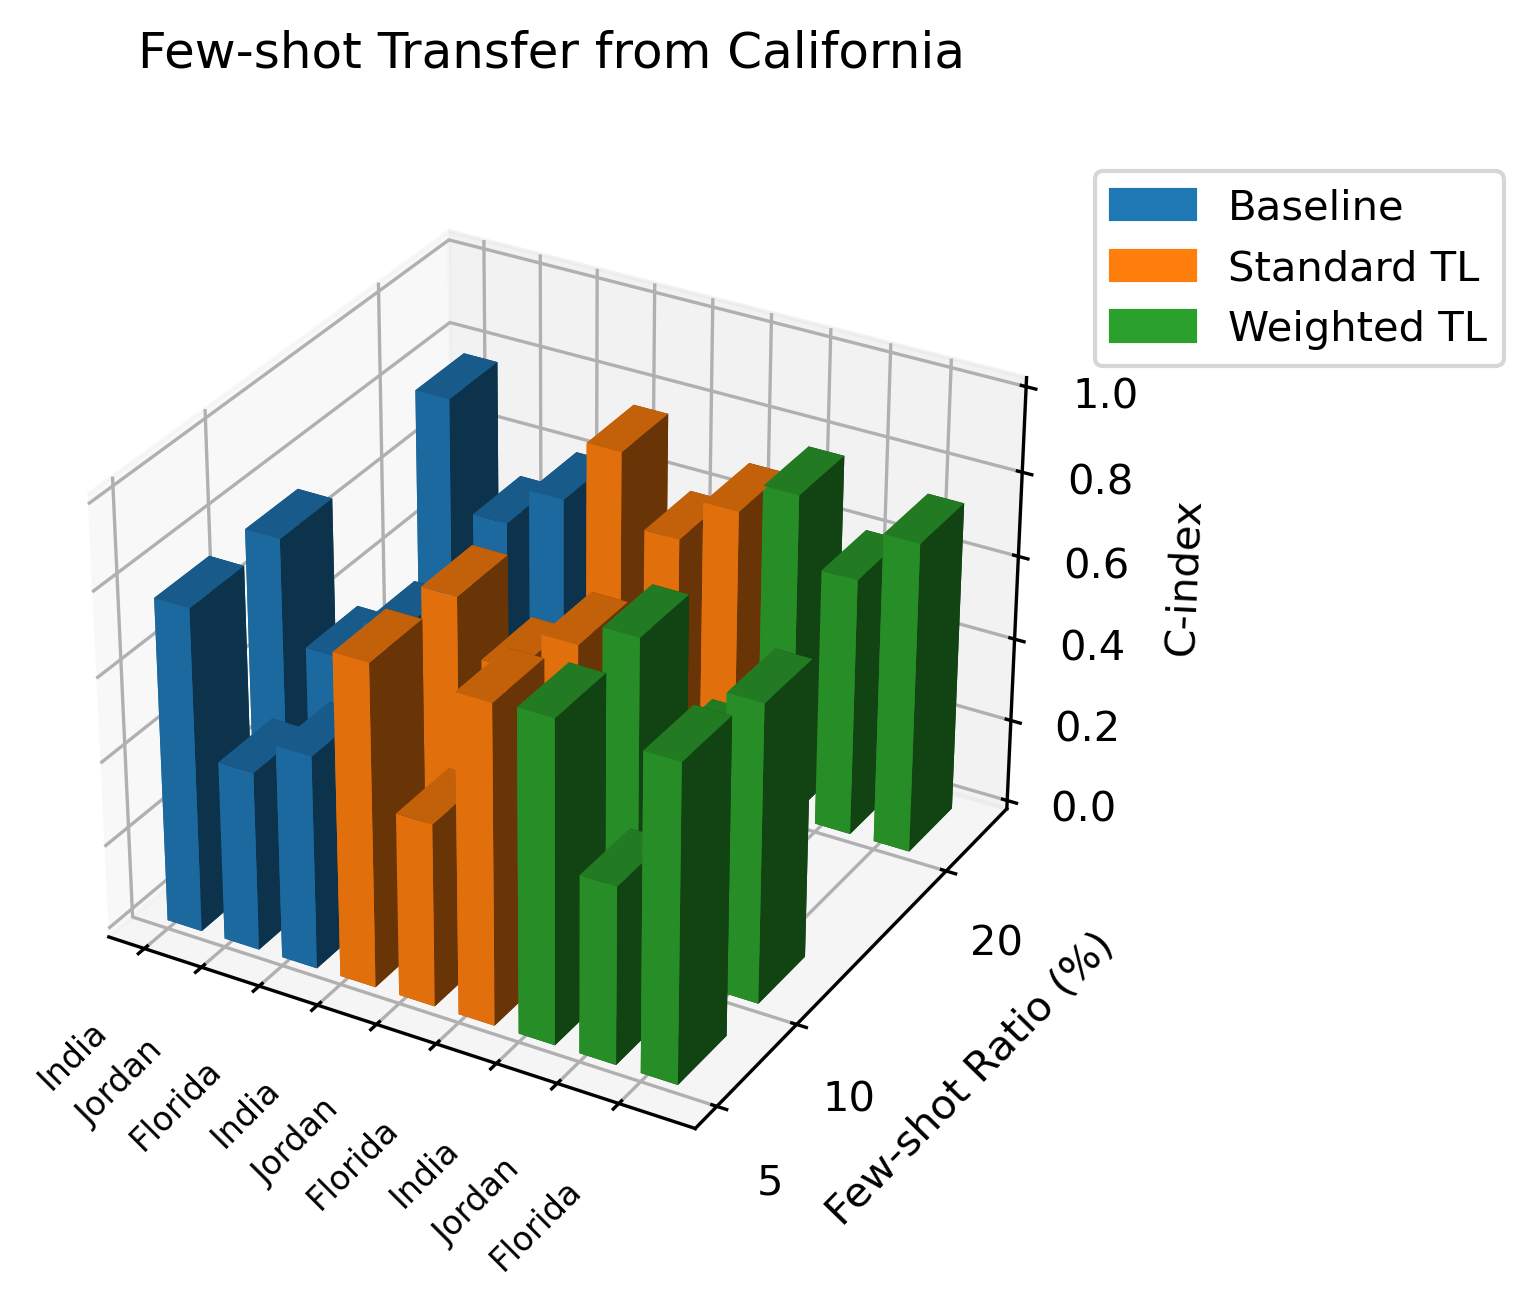

In [28]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.patches import Patch

# Setup
sources = ["India", "Jordan", "Florida", "California"]
model_types = ["Baseline", "Standard TL", "Weighted TL"]
ratios = [5, 10, 20]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Define source→target pairs
source_target_pairs = [
    ("India", "Jordan"), ("India", "Florida"), ("India", "California"),
    ("Jordan", "India"), ("Jordan", "Florida"), ("Jordan", "California"),
    ("Florida", "India"), ("Florida", "Jordan"), ("Florida", "California"),
    ("California", "India"), ("California", "Jordan"), ("California", "Florida")
]

# C-index values
cindex_data = [
    # India→Jordan
    [0.155, 0.541, 0.689], [0.318, 0.493, 0.682], [0.196, 0.595, 0.405],
    # India→Florida
    [0.425, 0.510, 0.550], [0.526, 0.716, 0.710], [0.522, 0.552, 0.637],
    # India→California
    [0.506, 0.857, 0.864], [0.625, 0.836, 0.855], [0.618, 0.820, 0.850],
    # Jordan→India
    [0.768, 0.764, 0.762], [0.766, 0.749, 0.775], [0.786, 0.770, 0.781],
    # Jordan→Florida
    [0.425, 0.433, 0.421], [0.526, 0.619, 0.548], [0.522, 0.599, 0.619],
    # Jordan→California
    [0.506, 0.755, 0.748], [0.625, 0.718, 0.707], [0.618, 0.704, 0.744],
    # Florida→India
    [0.768, 0.739, 0.752], [0.766, 0.737, 0.767], [0.786, 0.751, 0.770],
    # Florida→Jordan
    [0.155, 0.196, 0.385], [0.318, 0.426, 0.426], [0.196, 0.324, 0.284],
    # Florida→California
    [0.506, 0.347, 0.628], [0.625, 0.443, 0.368], [0.618, 0.417, 0.373],
    # California→India
    [0.768, 0.753, 0.760], [0.766, 0.749, 0.762], [0.786, 0.760, 0.773],
    # California→Jordan
    [0.155, 0.615, 0.696], [0.318, 0.439, 0.709], [0.196, 0.601, 0.655],
    # California→Florida
    [0.425, 0.554, 0.494], [0.526, 0.593, 0.577], [0.522, 0.613, 0.585],
]

# Plot
for source in sources:
    fig = plt.figure(figsize=(12, 6), dpi=300)
    ax = fig.add_subplot(111, projection='3d')

    transfers = [t for s, t in source_target_pairs if s == source]
    index_offset = source_target_pairs.index((source, transfers[0]))

    x_pos, y_pos, z_pos, dx, dy, dz, bar_colors = [], [], [], [], [], [], []

    for m_idx, model in enumerate(model_types):
        for t_idx, target in enumerate(transfers):
            for r_idx, ratio in enumerate(ratios):
                row = index_offset + t_idx * 3 + r_idx
                x = m_idx * len(transfers) + t_idx  # Group by model type
                y = ratio
                x_pos.append(x)
                y_pos.append(y)
                z_pos.append(0)
                dx.append(0.6)
                dy.append(3)
                dz.append(cindex_data[row][m_idx])
                bar_colors.append(colors[m_idx])

    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=bar_colors, shade=True)

    ax.set_ylabel('Few-shot Ratio (%)')
    ax.set_zlabel('C-index')
    ax.set_yticks(ratios)
    ax.set_zlim(0, 1)
    ax.set_title(f'Few-shot Transfer from {source}', pad=20)

    xtick_labels = model_types[0:1]*len(transfers) + model_types[1:2]*len(transfers) + model_types[2:3]*len(transfers)
    xtick_labels = transfers * len(model_types)

    ax.set_xticks(range(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)

    # Add spacing and legend
    plt.subplots_adjust(bottom=0.3)
    legend_patches = [Patch(color=colors[i], label=model_types[i]) for i in range(3)]
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()
